# Visual Analysis

This notebook has been created to support two main purposes:
* Based on an input image and a set of models, display the action-space probability distribution.
* Based on an input image and a set of models, visualize which parts of the image the model looks at.

## Usage

The workbook requires the following:
* A set of raw images captured from the front camera of the car
* One or more static model files (`model_*.pb`)
* The `model_metadata.json`

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

This workbook will require `tensorflow` and `cv2` to work.


## Installs and setups

If you are using an AWS SageMaker Notebook or Sagemaker Studio Lab to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [1]:
# Make sure you have the required pre-reqs

# import sys

# !{sys.executable} -m pip install --upgrade -r requirements.txt
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install tensorflow


## Imports

Run the imports block below:

In [ ]:
import json
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cv2

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1.io.gfile import GFile

from deepracer.model import load_session, visualize_gradcam_discrete_ppo, rgb2gray

import boto3
s3_resource = boto3.resource('s3')

# Use example files to understand how the notebook works
Only run this cell to use the example files

In [ ]:
# # Example / Alternative for logs on file-system
img_selection = 'logs/sample-model/pictures/*.png'
model_path = 'logs/sample-model/model'
iterations = [15, 30, 48]
model_type = 'example'

# Advanced - Fetch your own models from S3 / Minio

### Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [ ]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

### Configure S3 to get the models

Depending on which way you are training your model, you will need a slightly different way to load the data.


In [ ]:
PREFIX='model-name'   # Name of the model, without trailing '/'
BUCKET='bucket'       # Bucket name is default 'bucket' when training locally
PROFILE=None          # The credentials profile in .aws - 'minio' for local training
S3_ENDPOINT_URL=None  # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training
iterations = [1, 2, 3] #enter the numbers of your iterations you want to try (must exist in the model folder in S3)
img_selection = 'logs/sample-model/pictures/*.png' # replace with your own images as appropriate
model_type = 's3'

In [ ]:
# ### Configure and load files
#
if model_type=='s3':
    model_path = 'logs/' + PREFIX
    Path(model_path).mkdir(parents=True, exist_ok=True)
    s3_resource.Object(BUCKET, PREFIX + '/model/model_metadata.json').download_file(
       f'logs/{PREFIX}/model_metadata.json')
    for i in iterations:
        s3_resource.Object(BUCKET, PREFIX + '/model/model_' + str(i) + '.pb').download_file(
           f'logs/{PREFIX}/' + 'model_' + str(i) + '.pb')

# Load the models and pictures

Load the model metadata in, and define which sensor is in use.

In [3]:
with open("{}/model_metadata.json".format(model_path),"r") as jsonin:
    model_metadata=json.load(jsonin)
my_sensor = [sensor for sensor in model_metadata['sensor'] if sensor != "LIDAR"][0]
display(model_metadata)

{'action_space': [{'steering_angle': -30, 'speed': 1.0},
  {'steering_angle': -20, 'speed': 1.0},
  {'steering_angle': -20, 'speed': 2.0},
  {'steering_angle': -10, 'speed': 1.0},
  {'steering_angle': -10, 'speed': 2.0},
  {'steering_angle': 0, 'speed': 1.0},
  {'steering_angle': 0, 'speed': 2.0},
  {'steering_angle': 10, 'speed': 1.0},
  {'steering_angle': 10, 'speed': 2.0},
  {'steering_angle': 20, 'speed': 1.0},
  {'steering_angle': 20, 'speed': 2.0},
  {'steering_angle': 30, 'speed': 1.0}],
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'training_algorithm': 'clipped_ppo',
 'action_space_type': 'discrete',
 'version': '3'}

Load in the pictures from the pre-defined path.

In [4]:
picture_files = sorted(glob.glob(img_selection))
display(picture_files)

['logs/sample-model/pictures/dr-demo-1.png',
 'logs/sample-model/pictures/dr-demo-2.png',
 'logs/sample-model/pictures/dr-demo-3.png']

In [5]:
action_names = []
degree_sign= u'\N{DEGREE SIGN}'
for action in model_metadata['action_space']:
    action_names.append(str(action['steering_angle'])+ degree_sign + " "+"%.1f"%action["speed"])
display(action_names)

['-30° 1.0',
 '-20° 1.0',
 '-20° 2.0',
 '-10° 1.0',
 '-10° 2.0',
 '0° 1.0',
 '0° 2.0',
 '10° 1.0',
 '10° 2.0',
 '20° 1.0',
 '20° 2.0',
 '30° 1.0']

## Load the model files and process pictures
We will now load in the models and process the pictures. Output is a nested list with size `n` models as the outer and `m` picture as the inner list. The inner list will contain a number of values equal to the 

In [6]:
model_inference = []
models_file_path = []

for n in iterations:
    models_file_path.append("{}/model_{}.pb".format(model_path,n))
display(models_file_path)

for model_file in models_file_path:
    model, obs, model_out = load_session(model_file, my_sensor, False)
    arr = []
    for f in picture_files[:]:
        img = cv2.imread(f)
        img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model.close()
    tf.reset_default_graph()

['logs/sample-model/model/model_15.pb',
 'logs/sample-model/model/model_30.pb',
 'logs/sample-model/model/model_48.pb']

load graph: logs/sample-model/model/model_15.pb


2024-01-06 13:16:11.318763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


load graph: logs/sample-model/model/model_30.pb
load graph: logs/sample-model/model/model_48.pb


## Simulation Image Analysis - Probability distribution on decisions (actions)

We will now show the probabilities per action for the selected picture and iterations. The higher the probability of one single action the more mature is the model. Comparing different models enables the developer to see how the model is becoming more certain over time.

In [7]:
PICTURE_INDEX=1
display(picture_files[PICTURE_INDEX])

'logs/sample-model/pictures/dr-demo-2.png'

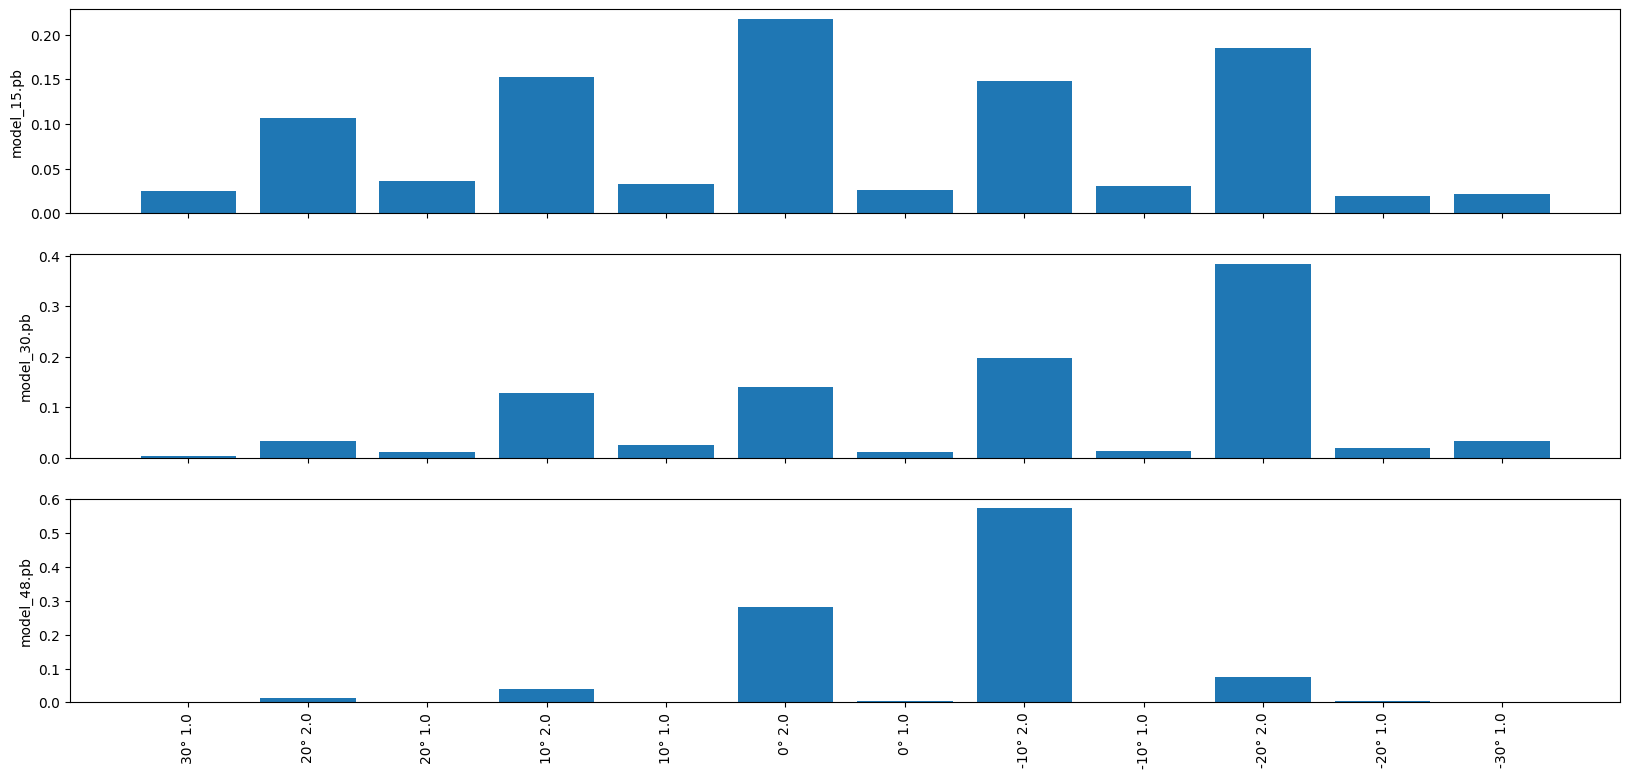

In [8]:
x = list(range(1,len(action_names)+1))

num_plots = len(iterations)
fig, ax = plt.subplots(num_plots,1,figsize=(20,3*num_plots),sharex=True,squeeze=False)

for p in range(0, num_plots):
    ax[p][0].bar(x,model_inference[p][PICTURE_INDEX][::-1])
    plt.setp(ax[p, 0], ylabel=os.path.basename(models_file_path[p]))
    
plt.xticks(x,action_names[::-1],rotation='vertical')
plt.show()

## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

In [9]:
heatmaps = []
view_models = models_file_path[0:len(iterations)]

for model_file in view_models:
    model, obs, model_out = load_session(model_file, my_sensor, False)
    arr = []
    for f in picture_files:
        img = cv2.imread(f)
        img = cv2.resize(img, dsize=(160, 120), interpolation=cv2.INTER_CUBIC)
        heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(action_names))
        heatmaps.append(heatmap)    

    tf.reset_default_graph()

load graph: logs/sample-model/model/model_30.pb
load graph: logs/sample-model/model/model_48.pb


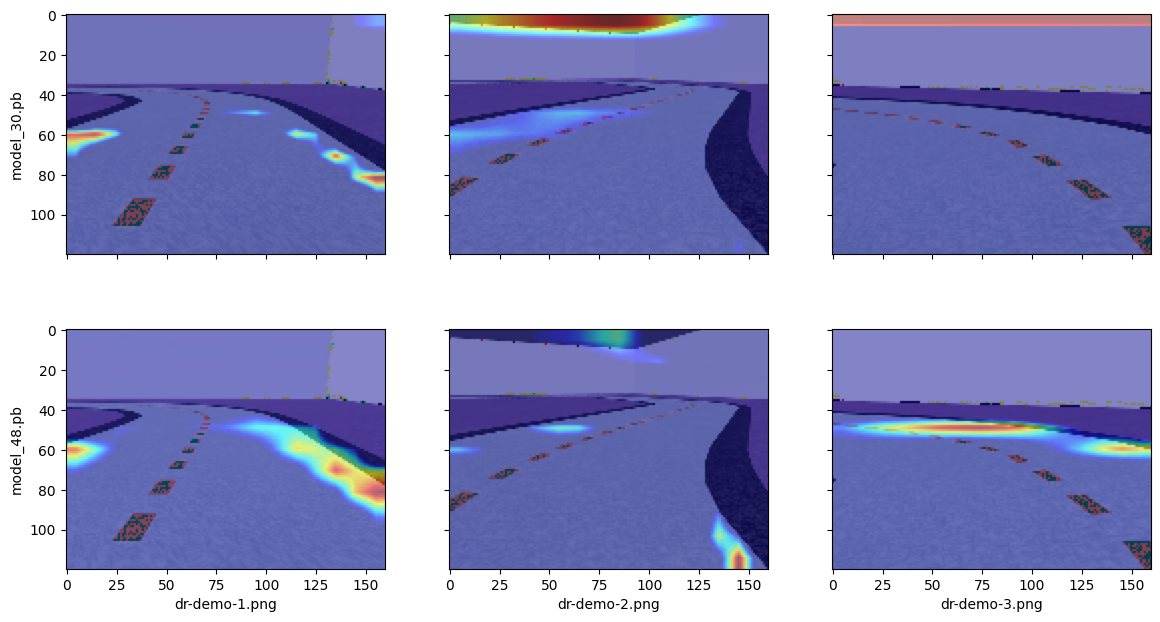

In [10]:
fig, ax = plt.subplots(len(view_models),len(picture_files),
                       figsize=(7*len(view_models),2.5*len(picture_files)), sharex=True, sharey=True, squeeze=False)

for i in list(range(len(view_models))):
    plt.setp(ax[i, 0], ylabel=os.path.basename(view_models[i]))
    for j in list(range(len(picture_files))):
        ax[i][j].imshow(heatmaps[i * len(picture_files) + j])
        plt.setp(ax[-1:, j], xlabel=os.path.basename(picture_files[j]))
       
plt.show()